In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# DataFrames 
players = pd.read_csv("datasets/players.csv")
players_stats = pd.read_csv("datasets/player_szn_stats.csv")
nba_teams = pd.read_csv("datasets/teams.csv")
szn_types = pd.read_csv("datasets/szn_types.csv")
szn_stats = pd.read_csv("datasets/Seasons_Stats.csv") 


In [19]:
def clean_name(s: str):
    """
    cleans the name of the players, in the szn stats dataset some have a '*' at the end of their name
    """
    if isinstance(s, str) and s.endswith("*"):
        return s[:-1]
    return s

In [20]:
szn_stats["Player"] = szn_stats["Player"].apply(clean_name)

In [143]:
merged = players_stats.merge(nba_teams, on="team_id")
merged = merged.merge(players, on="player_id")
merged["player_name"] = merged["first_name"] + " " + merged["last_name"]
print(merged.columns)
merged = merged[["player_id", "full_name", "player_name", "season_id", "league_id_x"]].drop_duplicates()
merged = merged[merged["league_id_x"] == 0]
# merged.columns


Index(['player_id', 'team_id', 'season_id', 'minutes', 'games_started',
       'games_played', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'ast', 'stl',
       'blk', 'tov', 'pts', 'orb', 'drb', 'trb', 'pf', 'season_type_id',
       'league_id_x', 'league_id_y', 'full_name', 'nba_player_id',
       'date_of_birth', 'first_name', 'last_name', 'height_inches',
       'weight_lb', 'player_name'],
      dtype='object')


### Descriptive analysis of the dataset

Lets take a look at who are the players and teams that have performed the best over the years. For this analysis we will only be looking at the NBA, and regular season statistics.


In [145]:
player_with_teams = szn_stats.merge(merged, left_on=["Player", "Year"], right_on=["player_name", "season_id"], how="left").sort_values(by="Year").dropna(subset=["Year"])
player_with_teams = player_with_teams.drop_duplicates(subset=["Player", "Year"])

In [118]:
# top_scoring_teams = player_with_teams.groupby("full_name").sum().sort_values(by="PTS", ascending=False).head(5)
# top_teams = top_scoring_teams.index

## Players

<Axes: title={'center': 'Top Scoring players'}, xlabel='Player', ylabel='Points'>

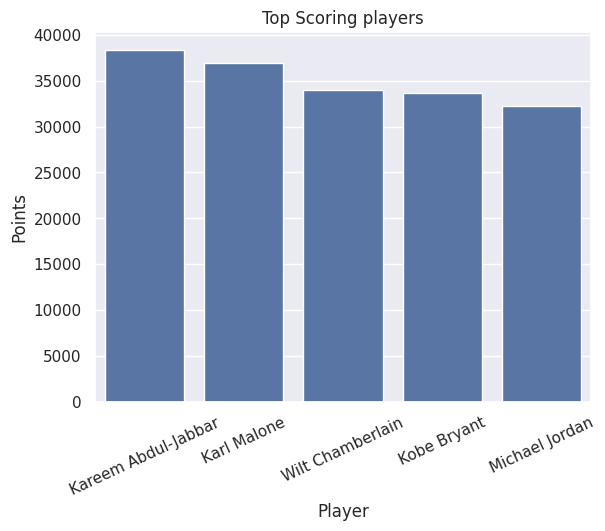

In [158]:
def get_top_scoring_players(players):
    """
    returns the top scoring players in the dataset
    """
    return players.groupby("Player").sum().sort_values(by="PTS", ascending=False)

def plot_top_scoring_players(players):
    top_scoring_players = get_top_scoring_players(players).head(5).reset_index() 
    plot = sns.barplot(data=top_scoring_players, y="PTS", x="Player")
    plot.set(title="Top Scoring players", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

szn_stats_test = szn_stats.iloc[10000:10010]
assert get_top_scoring_players(szn_stats_test).index.to_list() == ['James Worthy', 'Mahmoud Abdul-Rauf', 'Orlando Woolridge',
       'Mike Woodson', 'Danny Young', 'Mark Acres', 'Michael Young',
       'Alaa Abdelnaby', 'Haywoode Workman']
plot_top_scoring_players(szn_stats)

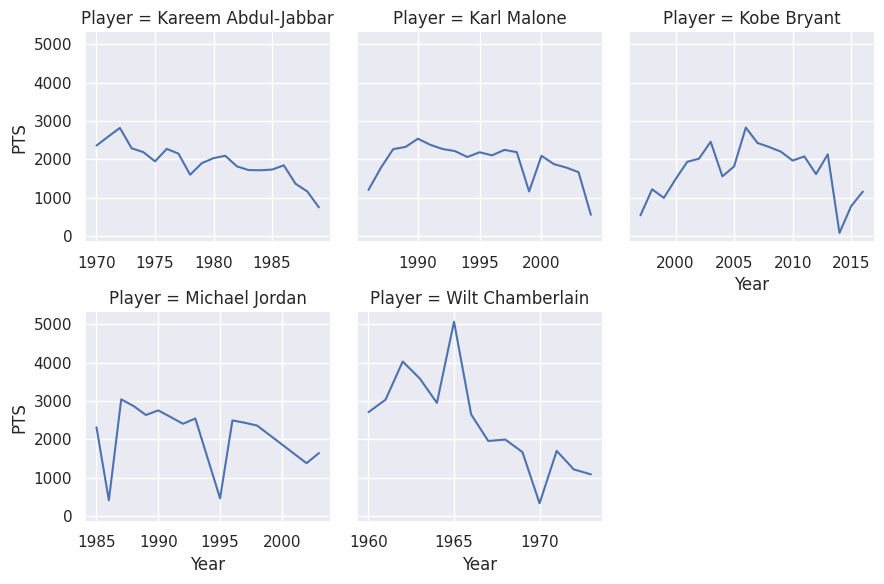

In [99]:
def plot_top_scoring_players_over_time():
    top_players = get_top_scoring_players(szn_stats).head(5).index
    players_per_year = szn_stats[szn_stats["Player"].isin(top_players)].groupby(["Player", "Year"]).sum().reset_index()
    g = sns.FacetGrid(players_per_year, col="Player", sharex=False, col_wrap=3)
    g.map(sns.lineplot, "Year", "PTS")
    return g

plot_top_scoring_players_over_time()

But are these really the best players? What if a player or team has played more games. Let's take a look at averages during the years, and see if there is anything that changes. 

<Axes: title={'center': 'Avg points scored per season'}, xlabel='Player', ylabel='Points'>

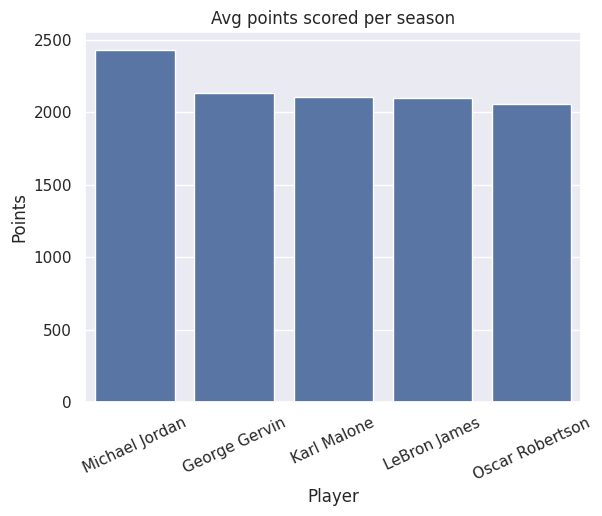

In [100]:
def get_players_with_highest_pts_avg(): 
    avg_top_scoring_players = szn_stats[["Player", "PTS"]].groupby("Player").median().sort_values(by="PTS", ascending=False).head(5)
    plot = sns.barplot(data=avg_top_scoring_players.reset_index(), y="PTS", x="Player")
    plot.set(title="Avg points scored per season", xlabel="Player", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

get_players_with_highest_pts_avg()
    

## Who have been the best shooters? (True shooting %)

True shooting percentage shows who have been the best shooters across all possible scoring types.

True shooting percentage is defined as

$$ TS\% = {PTS \over 2FGA + 0.475FTA} $$ 



                   GS        TS%
Player                          
Artis Gilmore   503.0  63.115459
DeAndre Jordan  561.0  61.854219
Cedric Maxwell  568.0  61.694717
Tyson Chandler  829.0  61.384457
Stephen Curry   568.0  61.183466


<Axes: title={'center': 'Top 5 shooters all time'}, xlabel='Player', ylabel='True Shooting Percentage'>

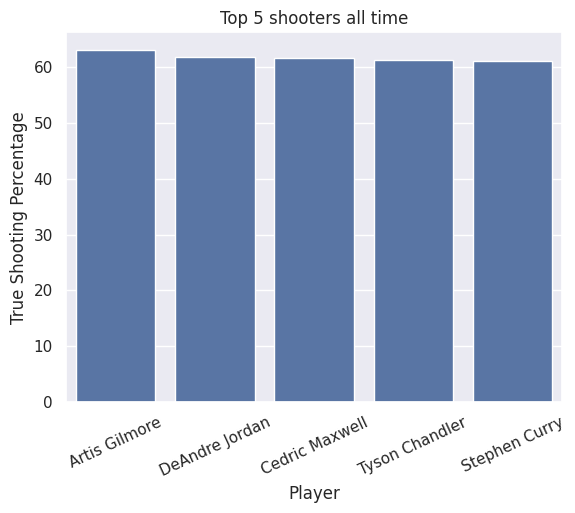

In [101]:
def get_true_shooting_percentages():
    best_shooters = szn_stats[["Player", "FGA", "FTA", "PTS", "GS", "Year"]].groupby("Player").sum().sort_values(by="PTS", ascending=False)
    best_shooters['TS%'] = (best_shooters['PTS'] / (2 * (best_shooters['FGA'] + 0.475 * best_shooters['FTA']))) * 100
    best_shooters = best_shooters[best_shooters["GS"] > 250][["GS","TS%"]].sort_values(by="TS%", ascending=False)
    plot = sns.barplot(data=best_shooters.reset_index().head(5), y="TS%", x="Player")
    plot.tick_params(axis="x", rotation=25)
    plot.set(title="Top 5 shooters all time", xlabel="Player", ylabel="True Shooting Percentage", )
    print(best_shooters.head(5))
    return plot

get_true_shooting_percentages()


## Effective field goal percentage

it shows how efficient the player is at shooting three point shots and also 2 point shots

and it is defined as follows:

$$ eFG\% = {FG + 0.5\times3PM \over FGA}$$

<Axes: title={'center': 'Top 5 players with effective field goal percentage'}, xlabel='Player', ylabel='eFG%'>

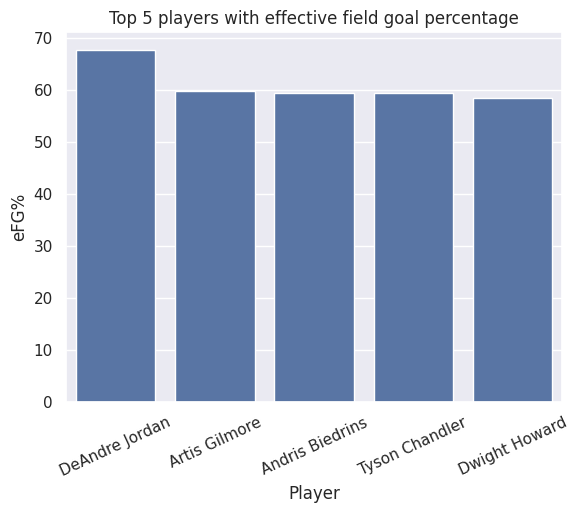

In [102]:
def show_effective_fild_goal_percentage():
    best_shooters = szn_stats[["Player", "FG", "FGA", "Year", "3P", "GS"]].groupby("Player").sum().sort_values(by="FG", ascending=False)
    best_shooters["eFG%"] = ((best_shooters["FG"] + 0.5 * best_shooters["3P"]) / best_shooters["FGA"]) * 100
    best_shooters = best_shooters[best_shooters["GS"] > 250][["GS", "eFG%"]].sort_values(by="eFG%", ascending=False)
    plot = sns.barplot(data=best_shooters.reset_index().head(5), y="eFG%", x="Player")
    plot.set(title="Top 5 players with effective field goal percentage", xlabel="Player", ylabel="eFG%")
    plot.tick_params(axis="x", rotation=25)
    return plot
show_effective_fild_goal_percentage()

Note that, it is interesting that our best shooters, are not in the part of the players with highest average points scored per season

## Teams 

lets analyse who have been the most dominants teams over the years

<Axes: title={'center': 'Top Scoring teams all Time'}, xlabel='Team', ylabel='Total Points'>

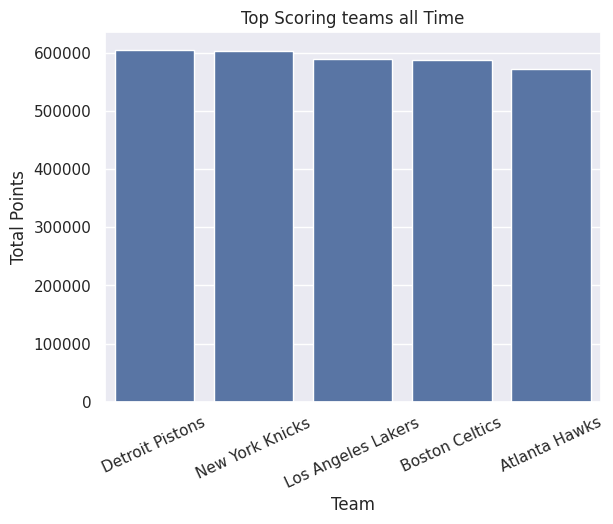

In [103]:
def plot_top_scoring_teams():
    """
    returns an axes with the top scoring teams all time as of 2020
    """
    plot = sns.barplot(data=top_scoring_teams.reset_index(), y="PTS", x="full_name")
    plot.set(title="Top Scoring teams all Time", xlabel="Team", ylabel="Total Points")
    plot.tick_params(axis="x", rotation=25)

    return plot

plot_top_scoring_teams()

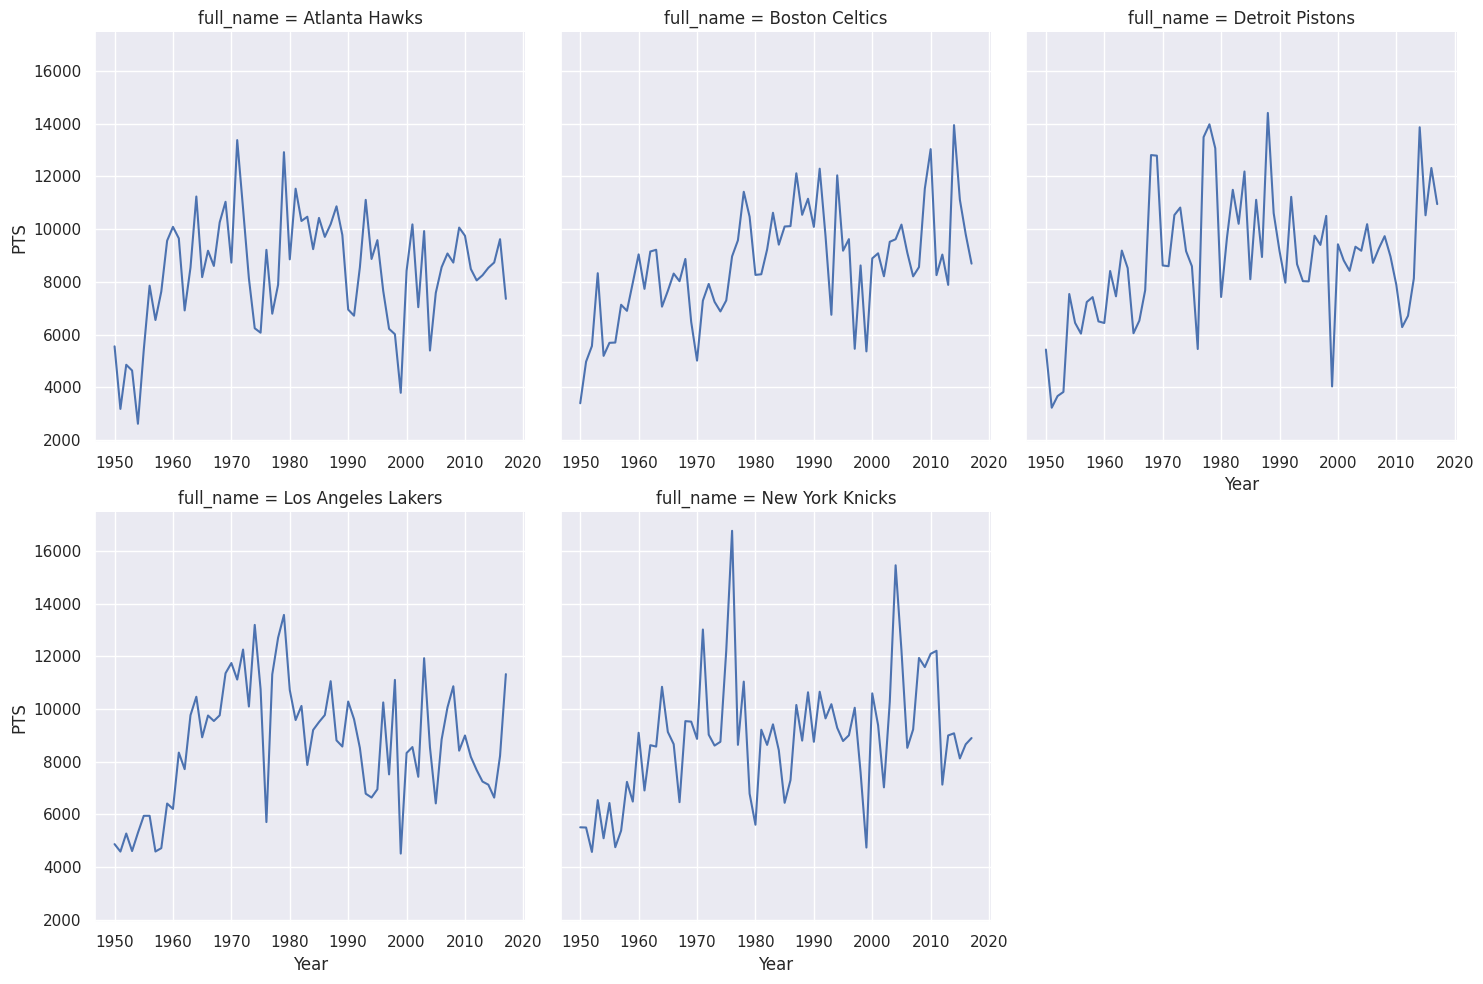

In [104]:
def plot_top_scoring_teams_over_time():
    team_points_per_year = player_with_teams[player_with_teams["full_name"].isin(top_teams)].groupby(["full_name", "Year"]).sum().reset_index()
    plot = sns.FacetGrid(data=team_points_per_year, col="full_name", col_wrap=3, height=5, sharex=False)
    plot.map(sns.lineplot, "Year", "PTS")
    return plot

plot_top_scoring_teams_over_time()

## Assists to turnover ratio

It is said that elite teams are the ones producing the most amounts of assists and the least turnovers, lets take a look at which teams have been the best at doing so over the years 

In [105]:
def teams_w_best_ast_tov_ration():
    teams_per_year = player_with_teams[player_with_teams["Year"] > 2000][["full_name", "TOV", "AST", "G"]].groupby("full_name").sum().reset_index()
    teams_per_year = teams_per_year[teams_per_year["TOV"] > 0]
    teams_per_year["AST/TOV"] = teams_per_year["AST"] / teams_per_year["TOV"]
    teams_per_year = teams_per_year[teams_per_year["G"] > 10000]
    teams_per_year = teams_per_year.sort_values(by="AST/TOV", ascending=False)
    print(teams_per_year.head(10))

teams_w_best_ast_tov_ration()

               full_name      TOV      AST        G   AST/TOV
7       Dallas Mavericks  22431.0  38996.0  17197.0  1.738487
9        Detroit Pistons  21119.0  35390.0  16051.0  1.675742
5          Chicago Stags  21099.0  34846.0  14787.0  1.651547
14    Los Angeles Lakers  19945.0  32914.0  14388.0  1.650238
27     San Antonio Spurs  20748.0  34067.0  16381.0  1.641941
8         Denver Nuggets  22318.0  36323.0  15977.0  1.627520
29             Utah Jazz  19363.0  31404.0  14031.0  1.621856
11       Houston Rockets  22804.0  36896.0  16854.0  1.617962
2          Brooklyn Nets  22444.0  36213.0  17279.0  1.613482
13  Los Angeles Clippers  23761.0  38335.0  16532.0  1.613358


Interestingly enough, these teams do not seem to be the most successful ones the NBA.